In [3]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

In [5]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

# load the data set
df = pd.read_csv('input/summer-travel-gps-dbscan.csv', encoding='utf-8')
df.head()

# load the data set
df = pd.read_csv('input/summer-travel-gps-full.csv', encoding='utf-8')
df.head()

In [6]:
# load the data set
df = pd.read_csv('input/earthquakes1970-2014.csv')
df.head()

,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,Source,EventID
0,00:40.2,24.139,102.503,31.0,7.5,Ms,90.0,NaN,NaN,0.0,NEI,1.970010e+09
1,35:51.8,-9.628,151.458,8.0,6.2,Ms,85.0,NaN,NaN,0.0,NEI,1.970011e+09
2,12:39.1,-34.741,178.568,179.0,6.1,Mb,59.0,NaN,NaN,0.0,NEI,1.970011e+09
3,07:08.6,6.825,126.737,73.0,6.1,Mb,91.0,NaN,NaN,0.0,NEI,1.970011e+09
4,05:39.0,60.280,-152.660,85.0,6.0,ML,0.0,NaN,NaN,NaN,AK,NaN


In [7]:
# represent points consistently as (lat, lon)
coords = df.as_matrix(columns=['Latitude', 'Longitude'])

# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 50 / kms_per_radian

C:\Users\mwals\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [8]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

Clustered 5,304 points down to 1,603 clusters, for 69.8% compression in 0.45 seconds
Silhouette coefficient: 0.175


In [9]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [10]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

In [11]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'Longitude':lons, 'Latitude':lats})
rep_points.tail()

,Longitude,Latitude
1598,-172.6411,-19.1711
1599,-176.5416,-17.1137
1600,-54.8821,-53.8813
1601,146.7599,20.7635
1602,-66.8478,19.0014


In [12]:
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
# that way we get the full details like city, country, and date from the original dataframe
rs = rep_points.apply(lambda row: df[(df['Latitude']==row['Latitude']) & (df['Longitude']==row['Longitude'])].iloc[0], axis=1)
rs.to_csv('input/earthquakes1970-2014-processed.csv', encoding='utf-8')
rs.tail()

,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,Source,EventID
1598,53:46.9,-19.1711,-172.6411,10.05,6.2,Mw,NaN,21.0,5.0,0.72,us,2.013110e+09
1599,48:32.1,-17.1137,-176.5416,371.00,6.5,Mw,NaN,22.0,5.0,0.82,us,2.013112e+09
1600,27:34.0,-53.8813,-54.8821,10.00,7.0,Mw,NaN,31.0,3.0,1.11,us,2.013113e+09
1601,38:08.1,20.7635,146.7599,16.06,6.2,Mw,NaN,14.0,4.0,0.74,us,2.013122e+09
1602,01:04.7,19.0014,-66.8478,28.00,6.4,Mw,NaN,21.0,1.0,1.42,us,2.014011e+09


In [13]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

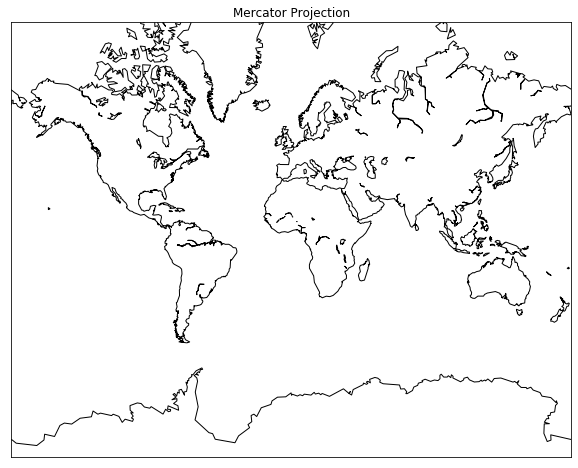

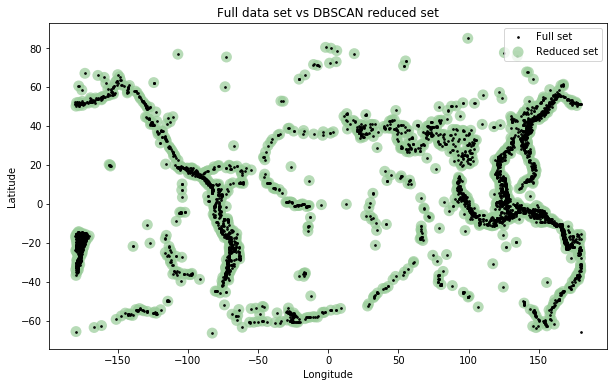

In [14]:
fig = plt.figure(num=None, figsize=(12, 8) )
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
plt.title("Mercator Projection")
#plt.show()




# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['Longitude'], rs['Latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['Longitude'], df['Latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()